# Measuring the impact of preventing Rosie from tagging congresspeople

In February, 2019, [Twitter blocked Rosie claiming she was a spammer](https://medium.com/serenata/a-suspens%C3%A3o-da-rosie-no-twitter-mostra-como-as-regras-para-bots-ainda-precisam-ser-lapidadas-94a0ab8b0003). This notebook tries to understand the impact of such attitude in terms of engagement with Rosie's tweets.

> Before starting, note that this script depends on importing to the environment four variables to allow access to Twitter's API:
>
>  1. `TWITTER_CONSUMER_KEY` 
>  1. `TWITTER_CONSUMER_SECRET`
>  1. `TWITTER_ACCESS_TOKEN_KEY`
>  1. `TWITTER_ACCESS_TOKEN_SECRET`

In [1]:
import os
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import tweepy

%matplotlib inline
pylab.rcParams['figure.figsize'] = (14, 8)

from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import SingleIntervalTicker, LinearAxis, Range1d, Span
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.palettes import Colorblind, Category10
output_notebook()

Loading BokehJS ...

In [2]:
BLOCK_DATE = datetime(2019, 2, 18)  # approx. as Twitter hasn't disclosured it precisely
ROSIE_FIRST_TWEET = 850769069473222656

auth = tweepy.OAuthHandler(
    os.environ.get("TWITTER_CONSUMER_KEY"),
    os.environ.get("TWITTER_CONSUMER_SECRET"),
)
auth.set_access_token(
    os.environ.get("TWITTER_ACCESS_TOKEN_KEY"),
    os.environ.get("TWITTER_ACCESS_TOKEN_SECRET"),
)
api = tweepy.API(auth, wait_on_rate_limit=True)


# Gettings all Rosie tweets

In [3]:
attrs = (
    "id",
    "created_at",
    "favorite_count",
    "retweet_count",
    "text"
)

def get_tweets(last_tweet=None):
    kwargs = {'max_id': last_tweet.id} if last_tweet else {}
    tweets = api.user_timeline("RosieDaSerenata", **kwargs)
    
    tweet = None
    for tweet in tweets:
        if tweet.retweeted:
            continue
        yield {attr: getattr(tweet, attr) for attr in attrs}
    
    if tweet and tweet.id != ROSIE_FIRST_TWEET:
        yield from get_tweets(tweet)

In [4]:
all_tweets = pd.DataFrame(get_tweets())
all_tweets['created_at'] = pd.to_datetime(all_tweets['created_at'])

all_tweets.shape

(1007, 5)

In [5]:
all_tweets.describe(include='all')

,id,created_at,favorite_count,retweet_count,text
count,1.007000e+03,1007,1007.000000,1007.000000,1007
unique,NaN,950,NaN,NaN,919
top,NaN,2017-06-11 17:12:26,NaN,NaN,🚨Gasto suspeito de Dep. PEDRO UCZAI (SC). Você...
freq,NaN,5,NaN,NaN,5
first,NaN,2017-04-08 17:55:27,NaN,NaN,NaN
last,NaN,2019-10-11 13:00:09,NaN,NaN,NaN
mean,9.657526e+17,NaN,50.094340,19.211519,NaN
std,9.068843e+16,NaN,71.051028,29.327518,NaN
min,8.507691e+17,NaN,4.000000,2.000000,NaN
25%,8.934383e+17,NaN,26.500000,10.000000,NaN


## Engagement as favorites and RTs

We are going to consider a tweet's total of favorites and RTs as a proxy of its level of engagement.

In [6]:
tweets = all_tweets[all_tweets['text'].str.startswith('🚨Gasto suspeito de')].copy()

tweets['engagement'] = tweets['favorite_count'] + tweets['retweet_count']

We are not particularly interested in daily seasonality. In return, resampling should help the autoregressor (see below).

In [7]:
# create time series
df = tweets.set_index('created_at')

agg = {
    'favorite_count' : ['sum'],
    'retweet_count' : ['sum'],
    'engagement' : ['count', 'sum']
    
}
df = df.resample('D', label='left').agg(agg)

# avoid annoying multiindex
df.columns = ['.'.join(col).strip() for col in df.columns.values]

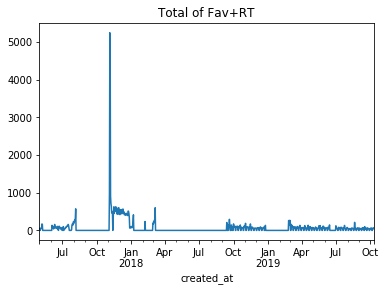

In [8]:
df['engagement.sum'].plot(title = 'Total of Fav+RT')

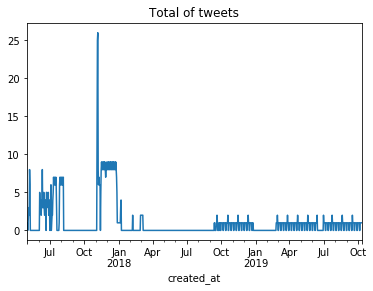

In [9]:
df['engagement.count'].plot(title = 'Total of tweets')

As we can see above, the number of tweets in time has changed drastically. We should take that into account in order to have a fair measure of engagement.

In [10]:
df = df[df['engagement.count'] > 0]

df['favorite_count'] = df['favorite_count.sum']/df['engagement.count']
df['retweet_count'] = df['retweet_count.sum']/df['engagement.count']
df['engagement'] = df['engagement.sum']/df['engagement.count']

# Engagement

In [11]:
p = figure(title='Engagement', plot_width=700, plot_height=400)

# Label Axes
p.xaxis[0].axis_label = 'Date'
p.yaxis[0].axis_label = 'Engagement (interactions/tweet)'

p.xaxis.formatter = DatetimeTickFormatter(
    years="%Y",
    months="%b %Y",
    days="%b %d",
)

# layouts
block_date = Span(location=BLOCK_DATE,
                              dimension='height', line_color='red',
                              line_dash='dashed', line_width=2)
p.add_layout(block_date)

colors = iter(Colorblind[5])

#p.line(df.index, df['engagement'], line_color=next(colors), legend='Fav+RT')
#p.line(df.index, df['favorite_count'], line_color=next(colors), legend='Fav')
#p.line(df.index, df['retweet_count'], line_color=next(colors), legend='RT')
p.scatter(df.index, df['engagement'], fill_color=next(colors), line_color=None, legend='Fav+RT')
p.scatter(df.index, df['favorite_count'], fill_color=next(colors), line_color=None, legend='Fav')
p.scatter(df.index, df['retweet_count'], fill_color=next(colors), line_color=None, legend='RT')

# clicking on the legend hides selection
p.legend.click_policy = "hide"
    
show(p) 

# Time series analysis

We are going to use ARIMA. Facebook's [fbprophet](https://facebook.github.io/prophet/docs/quick_start.html) is a good implementation and automatically finds *(p,d,q)* parameters for us.

In [12]:
from fbprophet import Prophet

In [13]:
# prepare working dataset to fit
wdf = df.reset_index().rename({'created_at':'ds', 'engagement':'y'}, axis=1)

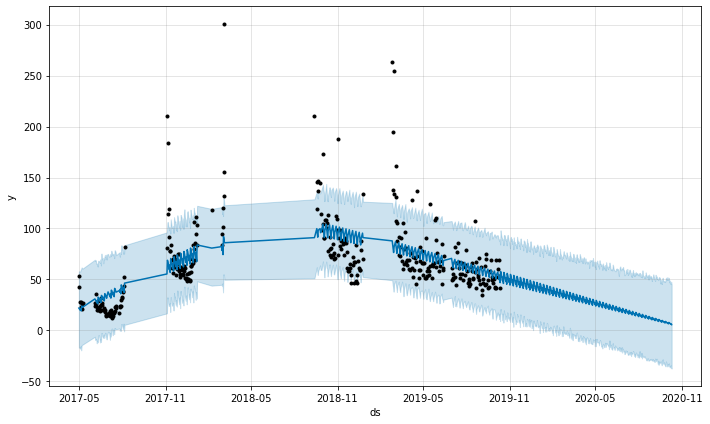

In [14]:
m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False, daily_seasonality=False)
m.fit(wdf)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = m.plot(forecast)

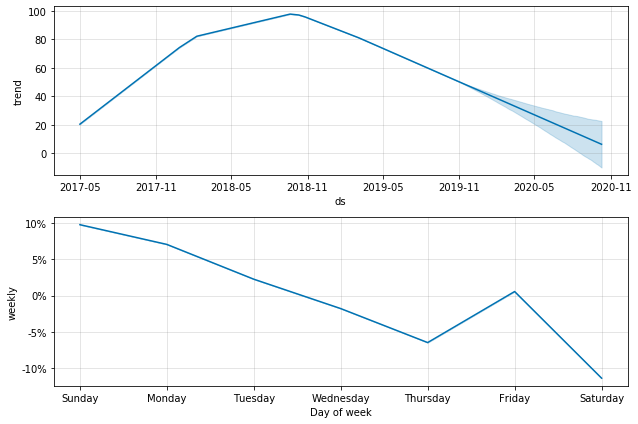

In [15]:
trend = m.plot_components(forecast)

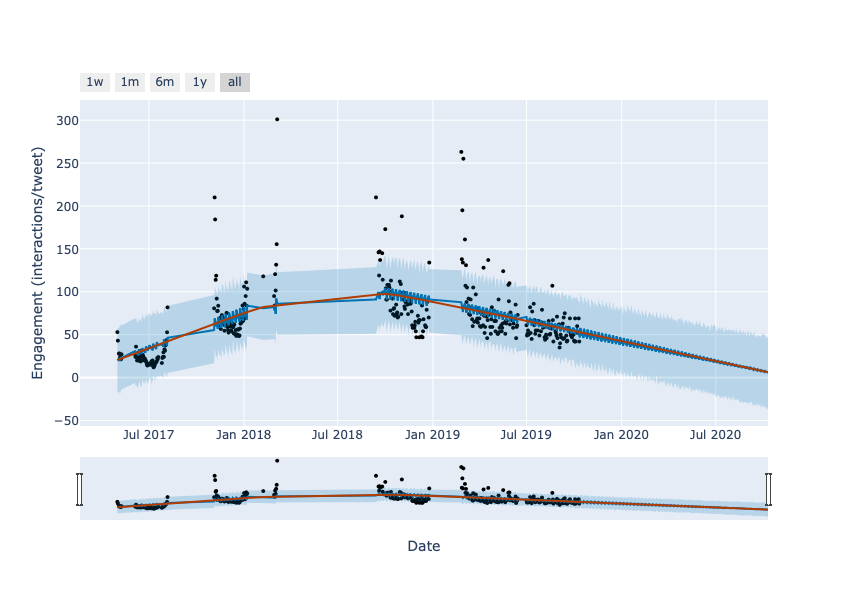

In [16]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)

fig = plot_plotly(m, forecast, trend=True, xlabel='Date', ylabel='Engagement (interactions/tweet)') 
py.iplot(fig)

## After the block 

In [17]:
# prepare working dataset to fit
wdf = df[df.index >= BLOCK_DATE]
wdf = wdf.reset_index().rename({'created_at':'ds', 'engagement':'y'}, axis=1)

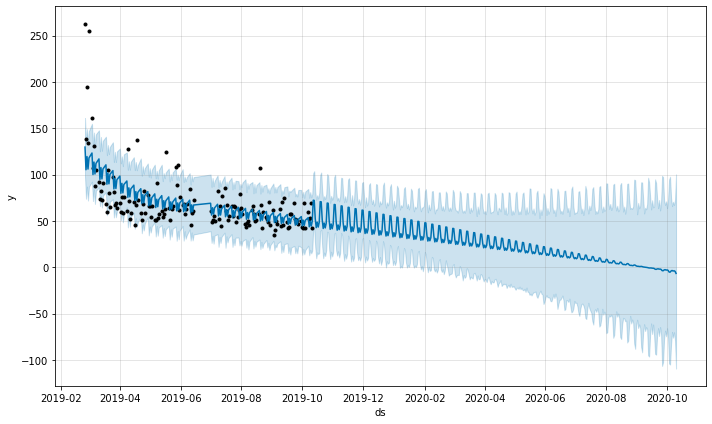

In [18]:
m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False, daily_seasonality=False)
m.fit(wdf)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = m.plot(forecast)

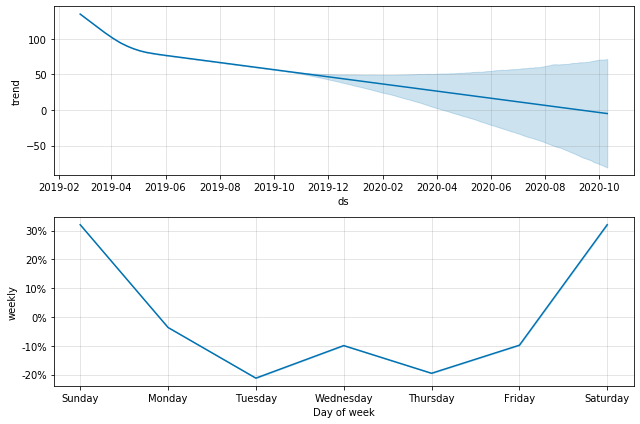

In [19]:
trend = m.plot_components(forecast)

Using plotly instead 

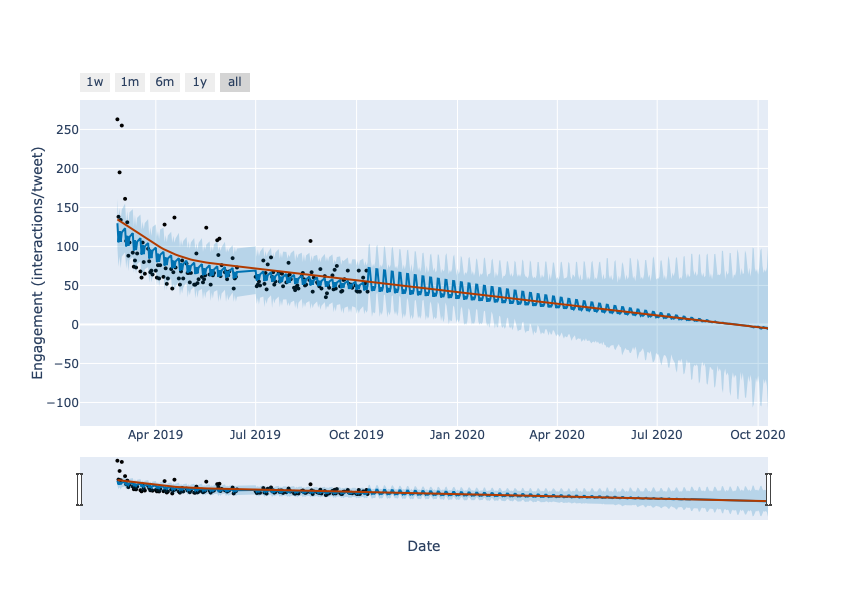

In [20]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)

fig = plot_plotly(m, forecast, trend=True, xlabel='Date', ylabel='Engagement (interactions/tweet)') 
py.iplot(fig)

# What can we say?

Despite significant gaps in the data, using an ARIMA model, the numbers suggest that **the impact of Twitter's block has been negative** in terms of engagement with Rosie's tweets. 

Note that the negative trend apparently started before and has been accentuated after the block. Considering recent data - where data points are more consistent - numbers gravitate clearly towards a negative trend. Between Fev/2019 and Apr/2019 - right after the block - the slope has higher negative value and continuously stabilizes, but in a negative trend. 